#### Testing speed of backpropagation vs speed of forward mode

The test will be for a single lane split into many different segments (and thus junctions with one incoming and one outgoing road) with different speeds. 
There will only be one single objective function, i.e. sum of densities at end of simulation.

In [2]:
import sys
sys.path.append('../src')

import network as nw
import torch
import road as rd
import junction as jn
import initial_and_bc as ibc
from torch.func import jacfwd
import time
import matplotlib.pyplot as plt
import numpy as np

#### Forward mode:
One single road split into 256 segments

In [42]:
n = 256
T = 30
def create_network(speeds):
    roads = []
    for i in range(n):
        if i == 0:
            # Add boundary function:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6]), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
            
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6]), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=None)
            
            roads.append(road)

    for i in range(len(speeds)):
        roads[i].Vmax[0] = speeds[i]

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)

    return objective_fnc

n = 256
T = 30
def create_bwd_network(n_params):
    # Assume n_params > 0
    roads = []
    for i in range(n):
        if i == 0:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=True), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        elif i < n_params:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=True), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)
    objective_fnc.backward()

    return objective_fnc


n = 256
T = 30
def create_network_nograd():
    # Assume n_params > 0
    roads = []
    for i in range(n):
        if i == 0:
            boundary_fnc = ibc.boundary_conditions(1, max_dens = 1, densities = torch.tensor([0.2]),
                                           time_jumps = [], in_speed = torch.tensor(50.0 / 3.6),
                                           L = 50)
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)
        else:
            road = rd.Road(1, 50, 5, torch.tensor([50.0 / 3.6], requires_grad=False), [], initial=lambda x : torch.ones_like(x)*0.2,
                           boundary_fnc=boundary_fnc)
            roads.append(road)

    junctions = []
    for i in range(n-1):
        junction = jn.Junction([roads[i], roads[i+1]], [0], [1], [[1.0]], [], [])
        junctions.append(junction)

    
    network = nw.RoadNetwork(roads, junctions, T)
    densities, _, _, _ = network.solve_cons_law()
    print(len(densities[0]))

    objective_fnc = torch.tensor(0.0)

    for road in network.roads:
        objective_fnc += torch.sum(road.rho)
    print(objective_fnc)

    return objective_fnc

In [20]:
start = time.time()
speed_1 = torch.ones(1) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_1)
end_1 = time.time()
print(f"Time used for one parameter: {end_1 - start}")
print(f"Jacobi matrix: {jacobian}")

speed_2 = torch.ones(2) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_2)
end_2 = time.time()
print(f"Time used for two parameter: {end_2 - end_1}")
print(f"Jacobi matrix: {jacobian}")
speed_4 = torch.ones(4) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_4)
end_3 = time.time()
print(f"Time used for 4 parameter: {end_3 - end_2}")
print(f"Jacobi matrix: {jacobian}")


speed_8 = torch.ones(8) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_8)
end_4 = time.time()
print(f"Time used for 8 parameter: {end_4 - end_3}")
print(f"Jacobi matrix: {jacobian}")
speed_16 = torch.ones(16) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_16)
end_5 = time.time()
print(f"Time used for 16 parameter: {end_5 - end_4}")
print(f"Jacobi matrix: {jacobian}")

speed_32 = torch.ones(32) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_32)
end_6= time.time()
print(f"Time used for 32 parameter: {end_6 - end_5}")
print(f"Jacobi matrix: {jacobian}")
speed_16 = torch.ones(16) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_16)
end_5 = time.time()
print(f"Time used for 16 parameter: {end_5 - end_4}")
print(f"Jacobi matrix: {jacobian}")

speed_32 = torch.ones(32) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_32)
end_6= time.time()
print(f"Time used for 32 parameter: {end_6 - end_5}")
print(f"Jacobi matrix: {jacobian}")

end_6 = time.time()
speed_64 = torch.ones(64) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_64)
end_7 = time.time()
print(f"Time used for 64 parameter: {end_7 - end_6}")
print(f"Jacobi matrix: {jacobian}")

speed_128 = torch.ones(128) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_128)
end_8 = time.time()
print(f"Time used for one parameter: {end_8 - end_7}")
print(f"Jacobi matrix: {jacobian}")

speed_256 = torch.ones(256) * (50 / 3.6)
jacobian = jacfwd(create_network)(speed_256)
end_9 = time.time()
print(f"Time used for one parameter: {end_9 - end_8}")
print(f"Jacobi matrix: {jacobian}")

26
GradTrackingTensor(lvl=2, value=
    tensor(460.7989)
)
Time used for one parameter: 103.45681643486023
Jacobi matrix: tensor([2.5428e-08])
26
GradTrackingTensor(lvl=2, value=
    tensor(460.7989)
)
Time used for two parameter: 103.24210524559021
Jacobi matrix: tensor([2.5428e-08, 2.5428e-08])


##### Backward mode:

In [50]:
n_param = 1
start = time.time()
create_bwd_network(n_param)
end_1 = time.time()
print(f"Time used for one parameter: {end_1 - start}")

n_param = 2
create_bwd_network(n_param)
end_2 = time.time()
print(f"Time used for 2 parameters: {end_2 - end_1}")

n_param = 4
create_bwd_network(n_param)
end_3 = time.time()
print(f"Time used for one parameter: {end_3 - end_2}")

n_param = 8
create_bwd_network(n_param)
end_4 = time.time()
print(f"Time used for 8 parameters: {end_4 - end_3}")

n_param = 16
create_bwd_network(n_param)
end_5 = time.time()
print(f"Time used for 16 parameter: {end_5 - end_4}")

n_param = 32
create_bwd_network(n_param)
end_6 = time.time()
print(f"Time used for 32 parameter: {end_6 - end_5}")

n_param = 64
create_bwd_network(n_param)
end_7 = time.time()
print(f"Time used for 64 parameters: {end_7 - end_6}")

n_param = 128
create_bwd_network(n_param)
end_8 = time.time()
print(f"Time used for 128 parameter: {end_8 - end_7}")

n_param = 256
create_bwd_network(n_param)
end_9 = time.time()
print(f"Time used for 256 parameter: {end_9 - end_8}")

26
tensor(460.7989, grad_fn=<AddBackward0>)
Time used for one parameter: 26.342349767684937


##### No grad:

In [54]:
for i in range(5):
    start = time.time()
    create_network_nograd()
    end = time.time()
    print(f"Time for no-grad simulation: {end - start}")

26
tensor(460.7989)
Time for no-grad simulation: 6.581805944442749
26
tensor(460.7989)
Time for no-grad simulation: 6.055769681930542
26
tensor(460.7989)
Time for no-grad simulation: 5.887840986251831
26
tensor(460.7989)
Time for no-grad simulation: 6.122480869293213
26
tensor(460.7989)
Time for no-grad simulation: 6.059426307678223


In [57]:
n_params = [1,2,4,8,16,32,64,128, 256]
times = [111.478, 111.189, 109.498, 106.117, 108.314, 104.503, 98.721,
         94.369, 87.1757]
times_2 = [104.83455, 106.66979, 106.64955, 104.04167, 105.4759, 103.953, 
           102.523, 97.515, 93.052]
times_3 = [102.1369, 106.129, 106.323, 101.1876, 100.917, 104.7378, 98.088,
           94.075, 86.62]
times_4 = [103.9419, 104.829, 104.304, 101.317, 101.0478, 99.8644,
           96.565, 93.508, 86.801]


times_bwd = [28.711, 24.882, 24.576, 25.604, 25.261, 25.028, 25.750,
             26.445, 25.8019]
times_bwd_2 = [25.6176, 25.3401, 25.154, 25.564, 26.893, 25.824, 27.378,
               27.325, 27.198]
times_bwd_3 = [26.342, 25.0856, 24.5076, 24.752, 24.675, 25.608, 27.2427,
               28.039, 27.686]

times_no_grad = [5.671, 5.762, 5.712, 5.789, 5.872]

Text(0, 0.5, 'Seconds [s]')

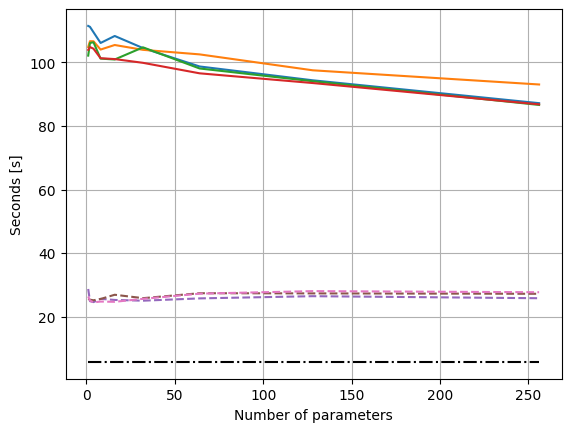

In [58]:
plt.plot(n_params, times, '-')
plt.plot(n_params, times_2, '-')
plt.plot(n_params, times_3, '-')
plt.plot(n_params, times_4, '-')
plt.plot(n_params, times_bwd, '--')
plt.plot(n_params, times_bwd_2, '--')
plt.plot(n_params, times_bwd_3, '--')


plt.plot([1, 256], [np.mean(np.array(times_no_grad)), np.mean(np.array(times_no_grad))], 'k-.')


plt.grid()
plt.xlabel("Number of parameters")
plt.ylabel("Seconds [s]")